# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [212]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [213]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [214]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [215]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [216]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)

# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [217]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for W.0
Gradient check passed!
Checking gradient for B.0
Gradient check passed!
Checking gradient for W.2
Gradient check passed!
Checking gradient for B.2
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [218]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for W.0
Gradient check passed!
Checking gradient for B.0
Gradient check passed!
Checking gradient for W.2
Gradient check passed!
Checking gradient for B.2
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [219]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.1

# Допишем код для процесса тренировки

In [310]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)

In [311]:
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down and train and val accuracy go up for every epoch
loss_history, train_history, val_history = trainer.fit()

Loss: 2.288554, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.274561, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.192873, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.367543, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.345543, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.285563, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.307667, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.213553, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.108468, Train accuracy: 0.206111, val accuracy: 0.215000
Loss: 1.986079, Train accuracy: 0.241778, val accuracy: 0.245000
Loss: 2.141684, Train accuracy: 0.267444, val accuracy: 0.263000
Loss: 2.195929, Train accuracy: 0.278333, val accuracy: 0.280000
Loss: 1.949978, Train accuracy: 0.283889, val accuracy: 0.286000
Loss: 1.808591, Train accuracy: 0.294889, val accuracy: 0.303000
Loss: 1.924358, Train accuracy: 0.327889, val accuracy: 0.337000
Loss: 1.616256, Train acc

In [295]:
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-2 )

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down and train and val accuracy go up for every epoch
loss_history, train_history, val_history = trainer.fit()

Loss: 1.033468, Train accuracy: 0.832000, val accuracy: 0.752000
Loss: 0.770753, Train accuracy: 0.829556, val accuracy: 0.755000
Loss: 1.078190, Train accuracy: 0.833000, val accuracy: 0.753000
Loss: 0.923629, Train accuracy: 0.834778, val accuracy: 0.743000
Loss: 0.653132, Train accuracy: 0.840111, val accuracy: 0.756000
Loss: 0.833948, Train accuracy: 0.837444, val accuracy: 0.758000
Loss: 1.143658, Train accuracy: 0.839333, val accuracy: 0.745000
Loss: 1.075282, Train accuracy: 0.844889, val accuracy: 0.755000
Loss: 0.573796, Train accuracy: 0.844333, val accuracy: 0.760000
Loss: 0.627782, Train accuracy: 0.846889, val accuracy: 0.753000
Loss: 0.729582, Train accuracy: 0.844778, val accuracy: 0.758000
Loss: 0.802733, Train accuracy: 0.845889, val accuracy: 0.758000
Loss: 0.796651, Train accuracy: 0.849111, val accuracy: 0.756000
Loss: 0.668013, Train accuracy: 0.847222, val accuracy: 0.763000
Loss: 0.860661, Train accuracy: 0.855889, val accuracy: 0.763000
Loss: 0.641329, Train acc

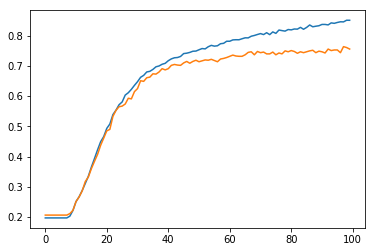

In [289]:
plt.plot(train_history)
plt.plot(val_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [309]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-2, learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 2.261040, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.196366, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.389546, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.300942, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.175324, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.201464, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.323867, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.094774, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.153350, Train accuracy: 0.201778, val accuracy: 0.212000
Loss: 2.182840, Train accuracy: 0.224000, val accuracy: 0.224000
Loss: 2.136062, Train accuracy: 0.254778, val accuracy: 0.258000
Loss: 2.001833, Train accuracy: 0.267667, val accuracy: 0.270000
Loss: 2.002243, Train accuracy: 0.279111, val accuracy: 0.282000
Loss: 1.741560, Train accuracy: 0.298778, val accuracy: 0.304000
Loss: 2.012643, Train accuracy: 0.327333, val accuracy: 0.328000
Loss: 1.594936, Train acc

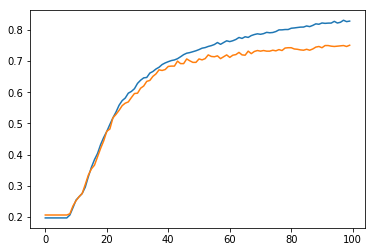

In [294]:
plt.plot(train_history)
plt.plot(val_history)

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [437]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-2, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 2.319949, Train accuracy: 0.197111, val accuracy: 0.207000
Loss: 1.823419, Train accuracy: 0.377222, val accuracy: 0.380000
Loss: 1.455470, Train accuracy: 0.533667, val accuracy: 0.529000
Loss: 1.623323, Train accuracy: 0.636222, val accuracy: 0.640000
Loss: 1.021754, Train accuracy: 0.687778, val accuracy: 0.658000
Loss: 1.715672, Train accuracy: 0.680778, val accuracy: 0.672000
Loss: 1.400947, Train accuracy: 0.704222, val accuracy: 0.669000
Loss: 1.141659, Train accuracy: 0.728222, val accuracy: 0.682000
Loss: 1.788742, Train accuracy: 0.746000, val accuracy: 0.697000
Loss: 0.732605, Train accuracy: 0.742889, val accuracy: 0.693000
Loss: 0.929410, Train accuracy: 0.748111, val accuracy: 0.700000
Loss: 1.224578, Train accuracy: 0.778222, val accuracy: 0.708000
Loss: 0.847060, Train accuracy: 0.769556, val accuracy: 0.698000
Loss: 0.808806, Train accuracy: 0.792111, val accuracy: 0.739000
Loss: 0.985104, Train accuracy: 0.802667, val accuracy: 0.743000
Loss: 1.221707, Train acc

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [314]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 2.335209, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.328431, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.299049, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.331323, Train accuracy: 0.200000, val accuracy: 0.000000
Loss: 2.309511, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.288285, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.233232, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.312694, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.228813, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.167031, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.954496, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.308101, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.046503, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.358806, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.954440, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.180699, Train acc

Loss: 1.296210, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.212689, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.489852, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.307903, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.242078, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.384888, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.418750, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.350319, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.222757, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.148645, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.496159, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.350594, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.114181, Train accuracy: 1.000000, val accuracy: 0.000000


Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [407]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 0)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, SGD(), learning_rate=3e-1, num_epochs=20, batch_size=5)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.290438, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.251098, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.398063, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.195262, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.923999, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.971436, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 2.582252, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.184963, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 1.401238, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 2.292314, Train accuracy: 0.466667, val accuracy: 0.066667
Loss: 1.216681, Train accuracy: 0.733333, val accuracy: 0.066667
Loss: 1.480750, Train accuracy: 0.600000, val accuracy: 0.000000
Loss: 1.316661, Train accuracy: 0.466667, val accuracy: 0.066667
Loss: 4.208045, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.455065, Train accuracy: 0.466667, val accuracy: 0.200000
Loss: 1.845850, Train acc

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **40%** на validation set.

In [446]:
# Let's train the best one-hidden-layer network we can

learning_rates = 1e-2
reg_strength = 1e-3
learning_rate_decay = 0.999
hidden_layer_size = 128
num_epochs = 200
batch_size = 64

best_classifier = None
best_val_accuracy = None
best_hypers = None

loss_history = []
train_history = []
val_history = []


# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above

best_val_accuracy = 0
for learning_rate in 10**np.linspace(-2,-2.5,3):
    for learning_rate_decay in [1, 0.999]:
        for hidden_layer_size in [100, 128]:
            print(f"*** Trainging with learning_rate={learning_rate}, learning_rate_decay={learning_rate_decay}, hidden_layer_size={hidden_layer_size}")

            model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = hidden_layer_size, reg = reg_strength)
            dataset = Dataset(train_X, train_y, val_X, val_y)
            trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=learning_rate, learning_rate_decay=learning_rate_decay, num_epochs=num_epochs, batch_size=batch_size)

            loss_history, train_history, val_history = trainer.fit()
            if best_val_accuracy < val_history[-1]:
                best_val_accuracy = val_history[-1]
                best_classifier = model
                best_hypers = [learning_rate, learning_rate_decay, hidden_layer_size]

print('best validation accuracy achieved: %f' % best_val_accuracy)

*** Trainging with learning_rate=0.01, learning_rate_decay=1, hidden_layer_size=100
Loss: 2.290657, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.339334, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.120095, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.254832, Train accuracy: 0.249444, val accuracy: 0.245000
Loss: 1.945137, Train accuracy: 0.292778, val accuracy: 0.292000
Loss: 1.944122, Train accuracy: 0.386111, val accuracy: 0.380000
Loss: 1.780635, Train accuracy: 0.441667, val accuracy: 0.414000
Loss: 1.400717, Train accuracy: 0.520889, val accuracy: 0.501000
Loss: 1.244798, Train accuracy: 0.561111, val accuracy: 0.553000
Loss: 1.470215, Train accuracy: 0.611444, val accuracy: 0.600000
Loss: 1.086767, Train accuracy: 0.629444, val accuracy: 0.630000
Loss: 1.051984, Train accuracy: 0.664222, val accuracy: 0.659000
Loss: 1.165337, Train accuracy: 0.681889, val accuracy: 0.658000
Loss: 1.069099, Train accuracy: 0.687556, val accuracy: 0.674000
Loss: 

Loss: 0.621139, Train accuracy: 0.915667, val accuracy: 0.767000
Loss: 0.694319, Train accuracy: 0.920667, val accuracy: 0.781000
Loss: 0.647607, Train accuracy: 0.922889, val accuracy: 0.776000
Loss: 0.636971, Train accuracy: 0.910889, val accuracy: 0.770000
Loss: 0.639504, Train accuracy: 0.923000, val accuracy: 0.773000
Loss: 0.681021, Train accuracy: 0.923444, val accuracy: 0.763000
Loss: 0.738507, Train accuracy: 0.908444, val accuracy: 0.765000
Loss: 0.641613, Train accuracy: 0.922222, val accuracy: 0.779000
Loss: 0.706137, Train accuracy: 0.921333, val accuracy: 0.774000
Loss: 0.898386, Train accuracy: 0.915111, val accuracy: 0.766000
Loss: 0.830933, Train accuracy: 0.930889, val accuracy: 0.772000
Loss: 0.636489, Train accuracy: 0.898778, val accuracy: 0.764000
Loss: 0.574025, Train accuracy: 0.931667, val accuracy: 0.778000
Loss: 0.885537, Train accuracy: 0.923889, val accuracy: 0.776000
Loss: 0.750434, Train accuracy: 0.916889, val accuracy: 0.766000
Loss: 0.788751, Train acc

Loss: 0.915877, Train accuracy: 0.884000, val accuracy: 0.772000
Loss: 0.710341, Train accuracy: 0.865000, val accuracy: 0.748000
Loss: 0.625512, Train accuracy: 0.888000, val accuracy: 0.753000
Loss: 0.722089, Train accuracy: 0.887556, val accuracy: 0.755000
Loss: 0.946969, Train accuracy: 0.873333, val accuracy: 0.769000
Loss: 0.665425, Train accuracy: 0.887889, val accuracy: 0.753000
Loss: 0.710396, Train accuracy: 0.874000, val accuracy: 0.768000
Loss: 0.799110, Train accuracy: 0.890778, val accuracy: 0.756000
Loss: 0.671964, Train accuracy: 0.891556, val accuracy: 0.766000
Loss: 0.753086, Train accuracy: 0.885778, val accuracy: 0.761000
Loss: 0.592374, Train accuracy: 0.890889, val accuracy: 0.762000
Loss: 0.688611, Train accuracy: 0.889556, val accuracy: 0.758000
Loss: 0.780697, Train accuracy: 0.901000, val accuracy: 0.764000
Loss: 0.691686, Train accuracy: 0.897000, val accuracy: 0.754000
Loss: 0.670682, Train accuracy: 0.905778, val accuracy: 0.765000
Loss: 0.876908, Train acc

Loss: 0.753844, Train accuracy: 0.928667, val accuracy: 0.769000
Loss: 0.792185, Train accuracy: 0.937778, val accuracy: 0.782000
Loss: 0.773102, Train accuracy: 0.937222, val accuracy: 0.785000
Loss: 0.678942, Train accuracy: 0.942000, val accuracy: 0.777000
Loss: 0.779406, Train accuracy: 0.939444, val accuracy: 0.776000
Loss: 0.822699, Train accuracy: 0.947889, val accuracy: 0.782000
Loss: 0.645556, Train accuracy: 0.939444, val accuracy: 0.777000
Loss: 0.731156, Train accuracy: 0.933889, val accuracy: 0.779000
Loss: 0.781223, Train accuracy: 0.936111, val accuracy: 0.772000
Loss: 0.635864, Train accuracy: 0.941667, val accuracy: 0.771000
Loss: 0.608996, Train accuracy: 0.932333, val accuracy: 0.769000
Loss: 0.714102, Train accuracy: 0.940222, val accuracy: 0.771000
Loss: 0.937962, Train accuracy: 0.944111, val accuracy: 0.780000
Loss: 0.876144, Train accuracy: 0.941111, val accuracy: 0.782000
Loss: 0.576204, Train accuracy: 0.938111, val accuracy: 0.775000
Loss: 0.656022, Train acc

Loss: 0.659407, Train accuracy: 0.905667, val accuracy: 0.748000
Loss: 0.889924, Train accuracy: 0.912889, val accuracy: 0.772000
Loss: 0.893545, Train accuracy: 0.908333, val accuracy: 0.757000
Loss: 0.768131, Train accuracy: 0.916111, val accuracy: 0.760000
Loss: 0.678403, Train accuracy: 0.905333, val accuracy: 0.762000
Loss: 0.743286, Train accuracy: 0.922556, val accuracy: 0.773000
Loss: 0.803495, Train accuracy: 0.920556, val accuracy: 0.767000
Loss: 0.745686, Train accuracy: 0.928667, val accuracy: 0.775000
Loss: 0.775927, Train accuracy: 0.923889, val accuracy: 0.767000
Loss: 0.729808, Train accuracy: 0.919000, val accuracy: 0.772000
Loss: 1.160410, Train accuracy: 0.920889, val accuracy: 0.763000
Loss: 0.576166, Train accuracy: 0.908222, val accuracy: 0.759000
Loss: 0.890173, Train accuracy: 0.926889, val accuracy: 0.765000
Loss: 0.836635, Train accuracy: 0.922778, val accuracy: 0.764000
Loss: 0.589443, Train accuracy: 0.923111, val accuracy: 0.760000
Loss: 0.714093, Train acc

Loss: 1.105490, Train accuracy: 0.800889, val accuracy: 0.747000
Loss: 0.830690, Train accuracy: 0.810222, val accuracy: 0.743000
Loss: 0.702588, Train accuracy: 0.806111, val accuracy: 0.744000
Loss: 0.989177, Train accuracy: 0.824111, val accuracy: 0.748000
Loss: 1.163147, Train accuracy: 0.824778, val accuracy: 0.744000
Loss: 0.937345, Train accuracy: 0.834444, val accuracy: 0.745000
Loss: 0.869560, Train accuracy: 0.837333, val accuracy: 0.748000
Loss: 0.906839, Train accuracy: 0.842444, val accuracy: 0.752000
Loss: 0.912629, Train accuracy: 0.819778, val accuracy: 0.737000
Loss: 0.840572, Train accuracy: 0.845556, val accuracy: 0.758000
Loss: 0.648339, Train accuracy: 0.839111, val accuracy: 0.740000
Loss: 0.546769, Train accuracy: 0.850111, val accuracy: 0.756000
Loss: 0.826215, Train accuracy: 0.843000, val accuracy: 0.746000
Loss: 0.784830, Train accuracy: 0.852667, val accuracy: 0.740000
Loss: 0.720003, Train accuracy: 0.865333, val accuracy: 0.750000
Loss: 0.934674, Train acc

Loss: 0.698940, Train accuracy: 0.946000, val accuracy: 0.778000
Loss: 0.726195, Train accuracy: 0.935556, val accuracy: 0.784000
Loss: 0.736176, Train accuracy: 0.940667, val accuracy: 0.781000
Loss: 0.605330, Train accuracy: 0.942667, val accuracy: 0.788000
Loss: 0.750945, Train accuracy: 0.916333, val accuracy: 0.773000
Loss: 0.764096, Train accuracy: 0.942111, val accuracy: 0.781000
Loss: 0.696028, Train accuracy: 0.941111, val accuracy: 0.789000
Loss: 0.822293, Train accuracy: 0.940222, val accuracy: 0.790000
Loss: 0.827210, Train accuracy: 0.941667, val accuracy: 0.789000
Loss: 0.626596, Train accuracy: 0.941111, val accuracy: 0.789000
Loss: 0.969822, Train accuracy: 0.943667, val accuracy: 0.799000
Loss: 0.876277, Train accuracy: 0.933333, val accuracy: 0.786000
Loss: 0.684671, Train accuracy: 0.948111, val accuracy: 0.788000
Loss: 0.681649, Train accuracy: 0.935333, val accuracy: 0.785000
Loss: 0.735517, Train accuracy: 0.946222, val accuracy: 0.785000
Loss: 0.577418, Train acc

Loss: 0.829365, Train accuracy: 0.884111, val accuracy: 0.775000
Loss: 0.807543, Train accuracy: 0.863111, val accuracy: 0.769000
Loss: 0.686154, Train accuracy: 0.887000, val accuracy: 0.772000
Loss: 0.619638, Train accuracy: 0.881889, val accuracy: 0.762000
Loss: 0.624870, Train accuracy: 0.886000, val accuracy: 0.768000
Loss: 0.552839, Train accuracy: 0.885444, val accuracy: 0.766000
Loss: 0.769073, Train accuracy: 0.878778, val accuracy: 0.758000
Loss: 0.805699, Train accuracy: 0.892778, val accuracy: 0.768000
Loss: 0.807244, Train accuracy: 0.880667, val accuracy: 0.763000
Loss: 0.844318, Train accuracy: 0.892444, val accuracy: 0.767000
Loss: 0.683965, Train accuracy: 0.892778, val accuracy: 0.767000
Loss: 0.614093, Train accuracy: 0.896222, val accuracy: 0.775000
Loss: 0.764849, Train accuracy: 0.894222, val accuracy: 0.768000
Loss: 0.621186, Train accuracy: 0.900333, val accuracy: 0.778000
Loss: 0.596889, Train accuracy: 0.899778, val accuracy: 0.771000
Loss: 0.795167, Train acc

Loss: 2.127448, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.182313, Train accuracy: 0.225556, val accuracy: 0.225000
Loss: 1.997960, Train accuracy: 0.262667, val accuracy: 0.262000
Loss: 2.057177, Train accuracy: 0.298333, val accuracy: 0.301000
Loss: 1.985704, Train accuracy: 0.354111, val accuracy: 0.352000
Loss: 1.777640, Train accuracy: 0.402444, val accuracy: 0.399000
Loss: 1.513263, Train accuracy: 0.442111, val accuracy: 0.435000
Loss: 1.419001, Train accuracy: 0.499222, val accuracy: 0.504000
Loss: 1.415398, Train accuracy: 0.527333, val accuracy: 0.524000
Loss: 1.582068, Train accuracy: 0.556333, val accuracy: 0.550000
Loss: 1.219952, Train accuracy: 0.586444, val accuracy: 0.567000
Loss: 1.304378, Train accuracy: 0.608889, val accuracy: 0.592000
Loss: 1.061124, Train accuracy: 0.625556, val accuracy: 0.606000
Loss: 1.424515, Train accuracy: 0.646444, val accuracy: 0.629000
Loss: 1.251839, Train accuracy: 0.664778, val accuracy: 0.653000
Loss: 0.921791, Train acc

Loss: 0.675857, Train accuracy: 0.924222, val accuracy: 0.765000
Loss: 0.720766, Train accuracy: 0.924222, val accuracy: 0.774000
Loss: 0.639511, Train accuracy: 0.932778, val accuracy: 0.791000
Loss: 0.579593, Train accuracy: 0.926889, val accuracy: 0.778000
Loss: 0.787552, Train accuracy: 0.927000, val accuracy: 0.784000
Loss: 0.783827, Train accuracy: 0.927889, val accuracy: 0.772000
Loss: 0.631094, Train accuracy: 0.916778, val accuracy: 0.767000
Loss: 0.625026, Train accuracy: 0.921444, val accuracy: 0.771000
Loss: 0.876645, Train accuracy: 0.918333, val accuracy: 0.777000
Loss: 0.575074, Train accuracy: 0.927667, val accuracy: 0.791000
Loss: 0.688420, Train accuracy: 0.929222, val accuracy: 0.780000
Loss: 0.993265, Train accuracy: 0.931889, val accuracy: 0.775000
Loss: 0.759939, Train accuracy: 0.930667, val accuracy: 0.776000
Loss: 0.542235, Train accuracy: 0.931222, val accuracy: 0.785000
Loss: 0.635911, Train accuracy: 0.924444, val accuracy: 0.776000
Loss: 0.686104, Train acc

Loss: 0.910284, Train accuracy: 0.835444, val accuracy: 0.755000
Loss: 0.791371, Train accuracy: 0.843778, val accuracy: 0.755000
Loss: 0.853587, Train accuracy: 0.847778, val accuracy: 0.753000
Loss: 0.983947, Train accuracy: 0.835000, val accuracy: 0.753000
Loss: 0.920452, Train accuracy: 0.838556, val accuracy: 0.750000
Loss: 0.742613, Train accuracy: 0.844333, val accuracy: 0.750000
Loss: 0.965605, Train accuracy: 0.844667, val accuracy: 0.753000
Loss: 0.782372, Train accuracy: 0.847222, val accuracy: 0.755000
Loss: 0.855417, Train accuracy: 0.849778, val accuracy: 0.755000
Loss: 1.008885, Train accuracy: 0.851778, val accuracy: 0.756000
Loss: 0.649673, Train accuracy: 0.854444, val accuracy: 0.762000
Loss: 0.872016, Train accuracy: 0.861000, val accuracy: 0.756000
Loss: 0.822163, Train accuracy: 0.854556, val accuracy: 0.766000
Loss: 0.777337, Train accuracy: 0.857556, val accuracy: 0.748000
Loss: 0.920880, Train accuracy: 0.864889, val accuracy: 0.757000
Loss: 0.676748, Train acc

Loss: 0.598469, Train accuracy: 0.940667, val accuracy: 0.780000
Loss: 0.783380, Train accuracy: 0.936333, val accuracy: 0.785000
Loss: 0.764048, Train accuracy: 0.928889, val accuracy: 0.780000
Loss: 0.720287, Train accuracy: 0.937889, val accuracy: 0.784000
Loss: 0.687205, Train accuracy: 0.937889, val accuracy: 0.792000
Loss: 0.674688, Train accuracy: 0.932000, val accuracy: 0.788000
Loss: 0.661293, Train accuracy: 0.933111, val accuracy: 0.786000
Loss: 0.648859, Train accuracy: 0.932444, val accuracy: 0.790000
Loss: 0.632235, Train accuracy: 0.940111, val accuracy: 0.793000
Loss: 0.543659, Train accuracy: 0.931333, val accuracy: 0.782000
Loss: 0.713781, Train accuracy: 0.937333, val accuracy: 0.783000
Loss: 0.679048, Train accuracy: 0.938667, val accuracy: 0.793000
Loss: 0.756347, Train accuracy: 0.937778, val accuracy: 0.786000
Loss: 0.723786, Train accuracy: 0.931778, val accuracy: 0.781000
Loss: 0.701489, Train accuracy: 0.937889, val accuracy: 0.791000
Loss: 0.648382, Train acc

Loss: 0.732082, Train accuracy: 0.903667, val accuracy: 0.758000
Loss: 0.738592, Train accuracy: 0.908111, val accuracy: 0.754000
Loss: 0.867379, Train accuracy: 0.898333, val accuracy: 0.752000
Loss: 0.797066, Train accuracy: 0.906444, val accuracy: 0.768000
Loss: 0.815910, Train accuracy: 0.907667, val accuracy: 0.762000
Loss: 0.614709, Train accuracy: 0.908000, val accuracy: 0.754000
Loss: 0.743973, Train accuracy: 0.905222, val accuracy: 0.760000
Loss: 0.813369, Train accuracy: 0.912111, val accuracy: 0.757000
Loss: 0.937952, Train accuracy: 0.912667, val accuracy: 0.758000
Loss: 0.646097, Train accuracy: 0.908111, val accuracy: 0.749000
Loss: 0.705811, Train accuracy: 0.910556, val accuracy: 0.761000
Loss: 0.891073, Train accuracy: 0.906333, val accuracy: 0.747000
Loss: 0.668032, Train accuracy: 0.905889, val accuracy: 0.762000
Loss: 0.780219, Train accuracy: 0.917111, val accuracy: 0.762000
Loss: 0.764325, Train accuracy: 0.914778, val accuracy: 0.757000
Loss: 0.741086, Train acc

Loss: 1.233305, Train accuracy: 0.669667, val accuracy: 0.646000
Loss: 1.195901, Train accuracy: 0.674889, val accuracy: 0.667000
Loss: 1.225283, Train accuracy: 0.685111, val accuracy: 0.666000
Loss: 1.470501, Train accuracy: 0.695556, val accuracy: 0.681000
Loss: 1.408452, Train accuracy: 0.701222, val accuracy: 0.679000
Loss: 1.092925, Train accuracy: 0.703333, val accuracy: 0.682000
Loss: 1.386295, Train accuracy: 0.707444, val accuracy: 0.679000
Loss: 1.230587, Train accuracy: 0.716444, val accuracy: 0.689000
Loss: 1.019622, Train accuracy: 0.720111, val accuracy: 0.691000
Loss: 1.171997, Train accuracy: 0.722556, val accuracy: 0.696000
Loss: 1.227625, Train accuracy: 0.722778, val accuracy: 0.692000
Loss: 0.976307, Train accuracy: 0.724889, val accuracy: 0.688000
Loss: 1.128638, Train accuracy: 0.728778, val accuracy: 0.706000
Loss: 0.958469, Train accuracy: 0.734889, val accuracy: 0.710000
Loss: 1.006448, Train accuracy: 0.739778, val accuracy: 0.708000
Loss: 0.982403, Train acc

Loss: 0.752332, Train accuracy: 0.896111, val accuracy: 0.761000
Loss: 0.508317, Train accuracy: 0.906444, val accuracy: 0.772000
Loss: 0.637506, Train accuracy: 0.903889, val accuracy: 0.769000
Loss: 0.724109, Train accuracy: 0.909889, val accuracy: 0.774000
Loss: 0.861985, Train accuracy: 0.907111, val accuracy: 0.772000
Loss: 0.671572, Train accuracy: 0.905444, val accuracy: 0.775000
Loss: 0.670550, Train accuracy: 0.904333, val accuracy: 0.763000
Loss: 0.744133, Train accuracy: 0.910444, val accuracy: 0.772000
Loss: 0.777518, Train accuracy: 0.904556, val accuracy: 0.765000
Loss: 0.669976, Train accuracy: 0.908889, val accuracy: 0.780000
Loss: 0.785448, Train accuracy: 0.912111, val accuracy: 0.775000
Loss: 0.733441, Train accuracy: 0.911444, val accuracy: 0.768000
Loss: 0.600946, Train accuracy: 0.906222, val accuracy: 0.771000
Loss: 0.703284, Train accuracy: 0.909222, val accuracy: 0.769000
Loss: 0.704934, Train accuracy: 0.912333, val accuracy: 0.772000
Loss: 0.642151, Train acc

Loss: 0.622964, Train accuracy: 0.831111, val accuracy: 0.752000
Loss: 0.689352, Train accuracy: 0.834778, val accuracy: 0.751000
Loss: 0.636914, Train accuracy: 0.835000, val accuracy: 0.750000
Loss: 0.816255, Train accuracy: 0.835667, val accuracy: 0.754000
Loss: 0.751880, Train accuracy: 0.839222, val accuracy: 0.755000
Loss: 1.126677, Train accuracy: 0.840667, val accuracy: 0.752000
Loss: 0.607221, Train accuracy: 0.844556, val accuracy: 0.748000
Loss: 0.805736, Train accuracy: 0.842889, val accuracy: 0.751000
Loss: 0.900008, Train accuracy: 0.846333, val accuracy: 0.754000
Loss: 0.824156, Train accuracy: 0.842444, val accuracy: 0.754000
Loss: 0.789059, Train accuracy: 0.846111, val accuracy: 0.753000
Loss: 0.841928, Train accuracy: 0.852556, val accuracy: 0.766000
Loss: 0.728978, Train accuracy: 0.849000, val accuracy: 0.755000
Loss: 0.725668, Train accuracy: 0.853667, val accuracy: 0.753000
Loss: 0.796165, Train accuracy: 0.857889, val accuracy: 0.760000
Loss: 0.667486, Train acc

Loss: 2.261010, Train accuracy: 0.252556, val accuracy: 0.259000
Loss: 1.857149, Train accuracy: 0.270778, val accuracy: 0.265000
Loss: 2.000917, Train accuracy: 0.278111, val accuracy: 0.274000
Loss: 2.015013, Train accuracy: 0.289333, val accuracy: 0.296000
Loss: 1.932132, Train accuracy: 0.316000, val accuracy: 0.321000
Loss: 1.936016, Train accuracy: 0.349667, val accuracy: 0.360000
Loss: 1.558412, Train accuracy: 0.382778, val accuracy: 0.373000
Loss: 1.897528, Train accuracy: 0.409444, val accuracy: 0.403000
Loss: 1.840995, Train accuracy: 0.440000, val accuracy: 0.435000
Loss: 1.757670, Train accuracy: 0.458222, val accuracy: 0.456000
Loss: 1.694480, Train accuracy: 0.478000, val accuracy: 0.470000
Loss: 1.443378, Train accuracy: 0.498222, val accuracy: 0.495000
Loss: 1.288679, Train accuracy: 0.518444, val accuracy: 0.507000
Loss: 1.269184, Train accuracy: 0.538778, val accuracy: 0.534000
Loss: 1.555582, Train accuracy: 0.551333, val accuracy: 0.540000
Loss: 1.331412, Train acc

Loss: 0.862206, Train accuracy: 0.868889, val accuracy: 0.760000
Loss: 0.816086, Train accuracy: 0.869556, val accuracy: 0.766000
Loss: 0.638584, Train accuracy: 0.869444, val accuracy: 0.761000
Loss: 0.606039, Train accuracy: 0.874778, val accuracy: 0.758000
Loss: 0.848155, Train accuracy: 0.875778, val accuracy: 0.771000
Loss: 0.805988, Train accuracy: 0.874889, val accuracy: 0.770000
Loss: 0.894534, Train accuracy: 0.877222, val accuracy: 0.767000
Loss: 0.649192, Train accuracy: 0.876444, val accuracy: 0.770000
Loss: 0.890807, Train accuracy: 0.876556, val accuracy: 0.769000
Loss: 0.736881, Train accuracy: 0.878778, val accuracy: 0.766000
Loss: 0.814563, Train accuracy: 0.877333, val accuracy: 0.765000
Loss: 0.698171, Train accuracy: 0.873000, val accuracy: 0.762000
Loss: 0.720357, Train accuracy: 0.876889, val accuracy: 0.768000
Loss: 0.727053, Train accuracy: 0.877111, val accuracy: 0.766000
Loss: 0.758886, Train accuracy: 0.882111, val accuracy: 0.767000
Loss: 0.716019, Train acc

Loss: 0.744779, Train accuracy: 0.775222, val accuracy: 0.724000
Loss: 1.096442, Train accuracy: 0.780444, val accuracy: 0.724000
Loss: 0.966291, Train accuracy: 0.780667, val accuracy: 0.728000
Loss: 0.694696, Train accuracy: 0.781667, val accuracy: 0.722000
Loss: 0.907847, Train accuracy: 0.787000, val accuracy: 0.734000
Loss: 1.259355, Train accuracy: 0.791222, val accuracy: 0.731000
Loss: 1.030523, Train accuracy: 0.792333, val accuracy: 0.728000
Loss: 1.005588, Train accuracy: 0.790222, val accuracy: 0.737000
Loss: 1.226922, Train accuracy: 0.793111, val accuracy: 0.737000
Loss: 0.708209, Train accuracy: 0.797333, val accuracy: 0.726000
Loss: 0.871210, Train accuracy: 0.801000, val accuracy: 0.728000
Loss: 0.857252, Train accuracy: 0.799222, val accuracy: 0.733000
Loss: 0.756684, Train accuracy: 0.806222, val accuracy: 0.732000
Loss: 1.151550, Train accuracy: 0.801333, val accuracy: 0.740000
Loss: 0.803568, Train accuracy: 0.805889, val accuracy: 0.741000
Loss: 0.740458, Train acc

Loss: 0.744043, Train accuracy: 0.913667, val accuracy: 0.780000
Loss: 0.729577, Train accuracy: 0.911778, val accuracy: 0.776000
Loss: 0.731808, Train accuracy: 0.915111, val accuracy: 0.779000
Loss: 0.855211, Train accuracy: 0.914667, val accuracy: 0.774000
Loss: 0.592350, Train accuracy: 0.914889, val accuracy: 0.771000
Loss: 0.616028, Train accuracy: 0.914222, val accuracy: 0.773000
Loss: 0.724034, Train accuracy: 0.917111, val accuracy: 0.771000
Loss: 0.565127, Train accuracy: 0.916333, val accuracy: 0.778000
Loss: 0.664112, Train accuracy: 0.916667, val accuracy: 0.773000
Loss: 0.717051, Train accuracy: 0.919111, val accuracy: 0.779000
Loss: 0.683243, Train accuracy: 0.914556, val accuracy: 0.782000
best validation accuracy achieved: 0.791000


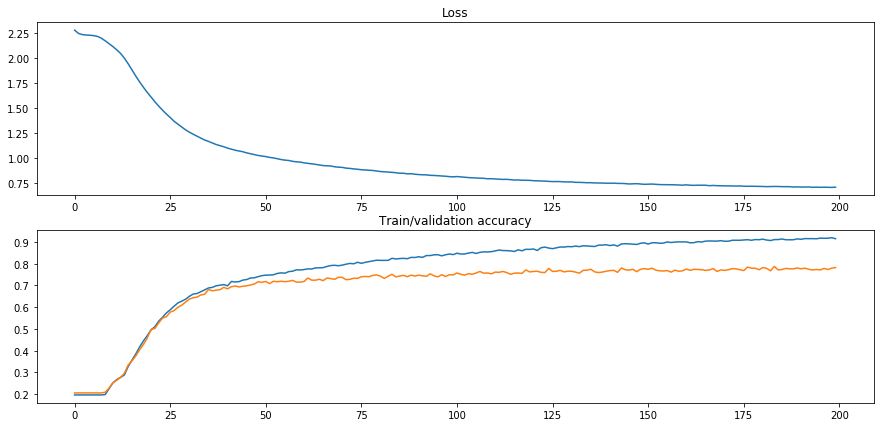

In [447]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [448]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.748000
